# Robot Kinematics, and how they apply to our robot's manipulator
This notebook gives an overview of using robot kinematics, what important terms mean, and how to apply them to the Minutebots' 2023 robot manipulator. The code will be in python, but the concepts all still apply in any programming language.

## Relevant terms
Don't worry if not all of these are immediately familiar.

**Scalar**: A single number. I'll use regular font for scalars, e.g. a = 3. 

**Vector**: A collection of scalars that we can do collective operations on. e.g. [1,2,3] is a vector. Lets call it **b** (I'll use lowercase bold for vectors), i.e. **b**=[1,2,3]. We can now multiply a x **b**, which means we multiply 3 by each element of **b**, giving us a x **b** = [3,6,9]. There are lots more operations you can do on vectors. 

**Matrix**: A collection of vectors, just like a vector was a collection of scalars. I'll use uppercase bold for matrices, like **C** = [[1,2,3], [4,5,6], [7,8,9]]. You can multiply and do all sorts of crazy stuff with matrices.

**Position**: A vector with 3 elements that describes where you are in the real world, but not where you're facing. Imagine we define [0,0,0] as the position of the middle of the field. Lets say our robot is on the charging station. Our robot is (maybe) 10 ft from the center along the long axis of the field, and 5 ft from the center along the short axis. It's also 8 inches up from the ground (since its on the charging station). Therefore, its position is [10ft, 5ft, 8in]

**Rotation**: We also want to know not only where our robot is, but which way its facing! Rotations can be described as a 3x3 matrix. Rotation matrices have some special properties that I won't go into (orthonormality, etc), but its enough to know that they are really useful. Matrices aren't the only way to describe rotations (you may have heard of quaternions, euler angles, axis-angle), but they are the most flexible.

**Pose**: A pose is a combination of a position and a rotation, that fully describes something's location in 3D space. If you have a position vector and a rotation matrix, you can combine them in a special way into a 4x4 matrix. Pose matrices are also sometimes called transforms. 

## Goal of this notebook
What we're going to do is define a series of pose matrices. Each one will describe how you get from one part of our manipulator to another (like from the base to the turntable, then from the turntable to pivot, etc). We'll have parameters in each pose matrix which will describe things like how far our arm is extended, or how much the wrist is rotated. We're then going to chain together all of these poses to get an matrix which will describe exactly where our grabber arm is, relative to the base of the robot.

What makes this cool is we can not only know exactly where our grabber is (this is called forward kinematics), but we can also run this process in reverse (inverse kinematics). So, if we want our grabber to be at a particular spot relative to the base of the robot (to pick up or put down a cone for example), we can calculate: what angle our turntable needs to be at, how far extended our arm needs to be, and where we need to pivot to. Full inverse kinematics (IK) is hard: it requires optimization and will probably require going to some outside libraries that are not FIRST-provided, if we want to do it. But, we can do some simple IK with just some understanding of our forward kinematics.


First, some quick set up code

In [72]:
import numpy
import sympy
from sympy import Matrix, eye, symbols, MatrixSymbol
import numpy as np
from sympy.vector import CoordSys3D, Vector
import matplotlib.axes as axes
import matplotlib.pyplot as plt

def plotCoordinateFrame(axis, T_0f, size=1, linewidth=3, label=""):
    p_f = numpy.array([ [ 0,0,0,1], [size,0,0,1], [0,size,0,1], [0,0,size,1]]).T;
    p_0 = numpy.dot(T_0f,p_f)
    # X-axis

    X = numpy.append( [p_0[:,0].T] , [p_0[:,1].T], axis=0 )
    Y = numpy.append( [p_0[:,0].T] , [p_0[:,2].T], axis=0 )
    Z = numpy.append( [p_0[:,0].T] , [p_0[:,3].T], axis=0 )
    axis.plot3D(X[:,0],X[:,1],X[:,2],'r-', linewidth=linewidth)
    axis.plot3D(Y[:,0],Y[:,1],Y[:,2],'g-', linewidth=linewidth)
    axis.plot3D(Z[:,0],Z[:,1],Z[:,2],'b-', linewidth=linewidth)
    axis.text(X[0,0], X[0,1], X[0,2], label, color='black')

def getPoseFromSympyCoords(coord_sys, parent_coord_sys):
    T = np.eye(4)
    T[:3, :3] = sympy.matrices.dense.matrix2numpy(coord_sys.rotation_matrix(parent_coord_sys).evalf(subs=robot_parameters))
    T[:3, 3:] = sympy.matrices.dense.matrix2numpy(coord_sys.position_wrt(parent_coord_sys).to_matrix(parent_coord_sys).evalf(subs=robot_parameters))
    return T

robot_parameters = {
}

First interesting thing we'll do is plot a single coordinate frame. Each coordinate frame will describe a pose. The first one will be the center of the robot. It'll be at position [0,0,0] with no rotation, and we'll base everything off of it.

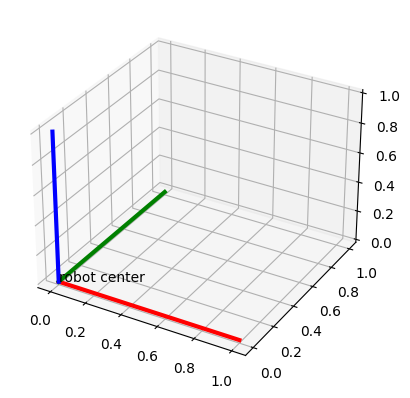

In [73]:
#define a symbolic coord frame:
origin = CoordSys3D('origin')
robot_center = origin.locate_new('robot_center', 0*origin.i)
                                 
#Plot it
ax = plt.figure().add_subplot(projection='3d')
plotCoordinateFrame(ax, getPoseFromSympyCoords(robot_center, origin), label='robot center')
plt.show()

Now lets define a frame that is offset positionally from our base frame, i.e. the base of the turntable.
We do this by specifying the offset of the new coordinate frame from the current coordinate frame along all 3 axes of the current coordinate frame.
I'll also do some book-keeping to keep track of all the various parameters of our robot.

Notice how the new coordinate frame is offset from the current one. This should match the real robot!

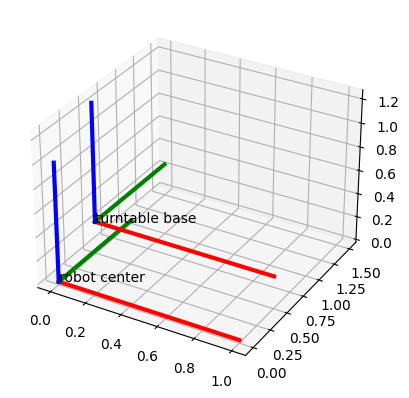

In [74]:
#Define a symbolic coord frame: 
#This vector (turntable_base_offset) describes the location of the turntable base, relative to the robot center
turntable_base_offset_x = symbols('turntable_base_offset_x')
turntable_base_offset_y = symbols('turntable_base_offset_y')
turntable_base_offset_z = symbols('turntable_base_offset_z')

# now we define some values for it...
robot_parameters['turntable_base_offset_x'] = 0
robot_parameters['turntable_base_offset_y'] = 0.5
robot_parameters['turntable_base_offset_z'] = 0.25

turntable_base = robot_center.locate_new('turntable_base', 
                                        robot_parameters['turntable_base_offset_x']*robot_center.i + \
                                        robot_parameters['turntable_base_offset_y']*robot_center.j + \
                                        robot_parameters['turntable_base_offset_z']*robot_center.k)
                                 
#Plot it
ax = plt.figure().add_subplot(projection='3d')
plotCoordinateFrame(ax, getPoseFromSympyCoords(origin, robot_center), label='robot center')
plotCoordinateFrame(ax, getPoseFromSympyCoords(turntable_base, robot_center), label='turntable base')
plt.show()

Now lets add a coordinate frame that will rotate with the top of the turntable, relative to the turntable base. For this, we'll define a symbolic value 'turntable_angle' which will describe the angle we've set the turntable to. We'll also set the rotation to occur around the 'k' axis of turntable_base, which corresponds to the z-axis (pointing straight up). 

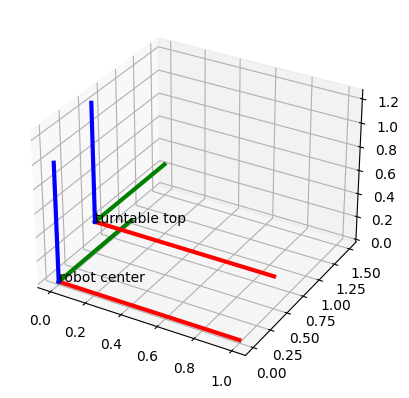

In [75]:
turntable_angle = symbols('turntable_angle')
robot_parameters['turntable_angle'] = 0.
turntable_top = turntable_base.orient_new_axis('turntable_top',
                                               turntable_angle,
                                               turntable_base.k)

#Plot it
ax = plt.figure().add_subplot(projection='3d')
plotCoordinateFrame(ax, getPoseFromSympyCoords(origin, robot_center), label='robot center')
plotCoordinateFrame(ax, getPoseFromSympyCoords(turntable_top, robot_center), label='turntable top')
plt.show()

Note that the turntable top is completely aligned with the robot center, just offset...

This isn't necessarily a problem, if our turntable angle is set to zero. Lets set it to a non-zero value to see what happens:

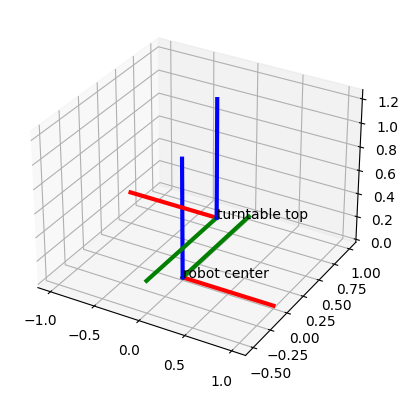

In [77]:
#Plot it
robot_parameters['turntable_angle'] = np.pi
ax = plt.figure().add_subplot(projection='3d')
plotCoordinateFrame(ax, getPoseFromSympyCoords(origin, robot_center), label='robot center')
plotCoordinateFrame(ax, getPoseFromSympyCoords(turntable_top, robot_center), label='turntable top')
plt.show()

The turntable top is now rotated by 180 degress (or Pi radians). Notice that its still offset location-wise from the robot center by the same amount, its just spun around. Set the line `robot_parameters['turntable_angle'] = np.pi` to be various values (I'd suggest starting with `np.pi/2`, `np.pi`, `3*np.pi/2`) to see what happens.

Next step is to set a coordinate frame for the pivot point. This is again an offset coordinate frame, but relative to the turntable top. As the turntable top frame rotates, so will our pivot point.

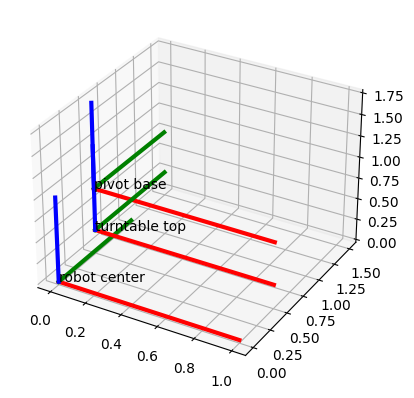

In [83]:
#Define a symbolic coord frame: 
turntable_base_offset_x = symbols('pivot_offset_x')
turntable_base_offset_y = symbols('pivot_offset_y')
turntable_base_offset_z = symbols('pivot_offset_z')

# now we define some values for it...
robot_parameters['pivot_offset_x'] = 0
robot_parameters['pivot_offset_y'] = 0
robot_parameters['pivot_offset_z'] = 0.5

robot_parameters['turntable_angle'] = 0

pivot_base = turntable_top.locate_new('pivot_base', 
                                        robot_parameters['pivot_offset_x']*turntable_top.i + \
                                        robot_parameters['pivot_offset_y']*turntable_top.j + \
                                        robot_parameters['pivot_offset_z']*turntable_top.k)
                                 
#Plot it
ax = plt.figure().add_subplot(projection='3d')
plotCoordinateFrame(ax, getPoseFromSympyCoords(origin, robot_center), label='robot center')
plotCoordinateFrame(ax, getPoseFromSympyCoords(pivot_base, robot_center), label='pivot base')
plotCoordinateFrame(ax, getPoseFromSympyCoords(turntable_top, robot_center), label='turntable top')
plt.show()

Do the same experiment with setting `robot_parameters['turntable_angle'] = 0` to different values, and see how the pivot base rotates with the turntable top, just like it should on our real robot

Next, we define a frame for the base of the arm, which is attached to the pivot base. It will have to swivel as we change the pivot angle, so we define another rotating frame, but this time around the y axis of the pivot base so our arm swings up and down:

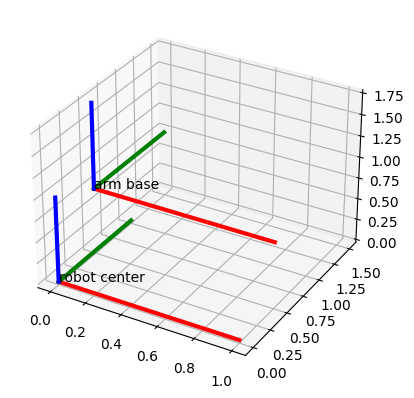

In [93]:
pivot_angle = symbols('pivot_angle')
robot_parameters['pivot_angle'] = 0.
arm_base = pivot_base.orient_new_axis('arm_base',
                                       pivot_angle,
                                       pivot_base.j)

#Plot it
ax = plt.figure().add_subplot(projection='3d')
plotCoordinateFrame(ax, getPoseFromSympyCoords(origin, robot_center), label='robot center')
plotCoordinateFrame(ax, getPoseFromSympyCoords(arm_base, robot_center), label='arm base')
plt.show()

Play with setting `robot_parameters['pivot_angle'] = 0.` to different values, and see the arm base coordinate frame tilt up and down.

Next up, a frame which sits at the end of the static part of our arm. We'll also define a frame the represents the end of the moving part of the arm. They'll sit out along the x-axis of the arm base frame. Do the same playing around with the value of `arm_extension_length` to see how the frames move when when we extend and retract the arm. You could also change the value in `robot_parameters['pivot_angle'] = 0.` to see what happens to the end of the arm when you change the pivot angle. 

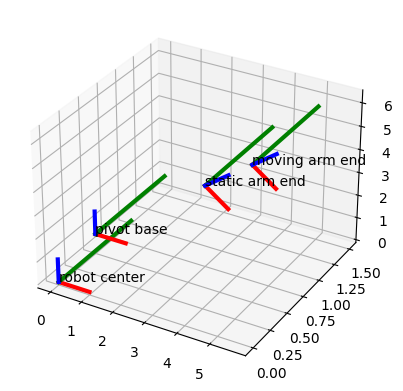

In [96]:
min_length_of_arm = symbols('min_length_of_arm')
arm_extension_length = symbols('arm_extension_length')

# now we define some values for it...
robot_parameters['min_length_of_arm'] = 5
robot_parameters['arm_extension_length'] = 2
robot_parameters['pivot_angle'] = -np.pi/4

static_arm_end = arm_base.locate_new('static_arm_end', 
                                        robot_parameters['min_length_of_arm']*arm_base.i)
moving_arm_end = static_arm_end.locate_new('moving_arm_end', 
                                        robot_parameters['arm_extension_length']*static_arm_end.i)
                                 
#Plot it
ax = plt.figure().add_subplot(projection='3d')
plotCoordinateFrame(ax, getPoseFromSympyCoords(origin, robot_center), label='robot center')
plotCoordinateFrame(ax, getPoseFromSympyCoords(pivot_base, robot_center), label='pivot base')
plotCoordinateFrame(ax, getPoseFromSympyCoords(static_arm_end, robot_center), label='static arm end')
plotCoordinateFrame(ax, getPoseFromSympyCoords(moving_arm_end, robot_center), label='moving arm end')
plt.show()